In [3]:
#Librarys

import pandas as pd
import time
from datetime import timedelta
import seaborn as sns
from sklearn import preprocessing
#from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import ta
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb


## **Functions:**

In [4]:
# Concatena as colunas data e hora que sao do tipo string e as transforma em uma coluna do tipo DateTime.

def formatedData(data,label1,label2):
    
    data.loc[:,label1] = pd.to_datetime(data[label1].astype(str)+' '+data[label2].astype(str))
    data = data.drop(label2, axis=1)
    
    return data

# Faz com que a distribuicao dos atributos tenham media 0 e desvio unitario.

def stdScaler(data_num): 
    
    if (isinstance (data_num, pd.DataFrame)):
        scaler = StandardScaler()
        data_num_x =scaler.fit_transform(data_num)
        data_num_final = pd.DataFrame(data_num_x,columns = data_num.columns, index = data_num.index)
        data_num = data_num_final
        return data_num
    else:
        return ("data nao e dataframe") 
    
def correlationVis(data,label): # visualiza a correlacao dos atributos com o target
    if (isinstance (data, pd.DataFrame)):
        corr_matrix_test = data.corr()
        return (corr_matrix_test[label].sort_values(ascending=False))
    else:
        return ("data nao e dataframe")
    
def categorySeparator (data): #separa atributos categoricos dos numericos
    if (isinstance (data, pd.DataFrame)):
        data_cat = data.select_dtypes(include=['object']).copy()
        data_num = data.select_dtypes(exclude =['object']).copy()
        return data_cat, data_num
    else :
        return ("data nao e dataframe")
    
def dataframeConcat (data,data1,data2): #concatena dois dataframes
    #if ((isinstance (data1, pd.DataFrame)) & (isinstance (data2, pd.DataFrame)) & (isinstance(data, pd.DataFrame))):
    data = pd.concat([data1,data2],axis =1)
    return data
    #else:
     #   return ("data nao e dataframe")
        
def labelSeparator (data,label): # separa um label do dataframe
    if (isinstance (data, pd.DataFrame)):
        data_label = data[label].copy()
        data = data.drop(label, axis=1)
        return data, data_label
    else:
        return ("data nao e dataframe")

    
def setTarget (data,numberRows = 5):
    if (isinstance (data, pd.DataFrame)):
        data['Difference'] = data['Close']- data['Low']
        data['Target'] = data['Difference'].iloc[numberRows:len(data)].reset_index(None, True)
        data = data.dropna(0).reset_index(None, True)
        return data
    else:
        return ("data nao e dataframe")
    
def setTargetClass (data, interval = 50, label = 'Target'):
    if (isinstance (data, pd.DataFrame)):
        data['Target_Class']= data[label].apply(lambda x: 'Up' if x>= interval  else( 'Down' if x <= interval*(-1) else 'Stay'))
        return data
    else:
        return("data nao e dataframe")
    
def countDay(data):
    if(isinstance (data, pd.DataFrame)):
        data['CountDay'] = 1 + ((data['Date'].dt.day - data['Date'][0].day) + 
        30*(data['Date'].dt.month - data['Date'][0].month) +
        365*(data['Date'].dt.year - data['Date'][0].year))
        return data
    else:
        return ('data nao e dataframe')
    
    
def dropRowsMinute (data,numberRows =50, label = 'DayMinute') :
    if (isinstance (data, pd.DataFrame)):
        data.where(data[label] >= numberRows, inplace = True )
        data = data.dropna(0).reset_index(None, True)
        return data
    else:
        return ('data nao e dataframe')
    
def minuteDay (data):
    if (isinstance(data, pd.DataFrame)):
        
        firstMinuteDay = data_formated['Date'][0];
        list_minutes= [] ;
        for col in data_formated['Date']:
            if( col.day == firstMinuteDay.day):
                list_minutes.insert(len(list_minutes), col.minute + col.hour*60 - 
                                    (60*firstMinuteDay.hour + firstMinuteDay.minute))
            else:
                firstMinuteDay = col
                list_minutes.insert(len(list_minutes), col.minute + col.hour*60 - 
                                    (60*firstMinuteDay.hour + firstMinuteDay.minute))
                
        return list_minutes
        
    else:
        return('data nao e dataframe')
    
def setMaxTarget (data, shift = 30):
    if (isinstance (data, pd.DataFrame)):
        list_aux=[]
    
        for index in data['Close'].index:
            diff = data['Close'].iloc[index:index +shift] - data['Close'].iloc[index]
            if(diff.max()>= np.abs(diff.min())):
                list_aux.insert(len(list_aux),diff.max())
            else:
                list_aux.insert(len(list_aux),diff.min())

        return list_aux
    
    else:
        return ('data nao e dataframe')      
    
def categoricBinarizer(data_cat): # transforma os atributos categoricos em binario e seus titulos viram o titulo do 
    if (isinstance (data_cat, pd.DataFrame)):#atributo concatenado com o valor do atributo categorico
        inc = 0
        for column in data_cat:
            inc = inc +1
            encoder_cat = LabelEncoder()
            data_cat_encoded = encoder_cat.fit_transform(data_cat.iloc[:,inc-1:inc])
            encoder_hot = OneHotEncoder()
            data_cat_hot_encoded= encoder_hot.fit_transform(data_cat_encoded.reshape(-1,1))
    
            for x in encoder_cat.classes_:
                labels_dataFrame = data_cat.columns[inc -1] + encoder_cat.classes_ 
    
            if (inc == 1):
                z = data_cat_hot_encoded.toarray()
                a = pd.DataFrame(z, columns = labels_dataFrame, index = data_cat.index)
            if (inc > 1):
                z = data_cat_hot_encoded.toarray()
                b = pd.DataFrame(z, columns = labels_dataFrame, index = data_cat.index)
                a = pd.concat([a,b], axis =1)
    
        data_cat = a
        return data_cat
    else:
        return ("data nao e dataframe")

            

In [5]:
data = pd.read_csv('Formatado_WIN@N_M1_201801020900_201812031809.csv', sep = ';', engine = 'python')
data = pd.DataFrame(data)
data_formated = data

### **List of Technical Indicator Index**

**Momentum Indicators:**

    - Relative Strengh Index(RSI) 

    - Rate of Change(ROC)

    - Stochastic Oscillator(SR) 
    
    
**Volume Indicators:**

    - Chakin Money Flow(CMF)
    
    - Volume Weighted Average Price(VWAP)
    
    - Force Index(FI)
    
**Volatility Indicators:**

    - Average True Range(ATR)
    
    - Bollinger High Band Indicator(BHB)
    
**Trende Indicators:**

    - Moving Average Convergence Divergence(MACD)
    
    - Average Directional Index(ADX)
    
    - Detrended Price Oscillator(DPO)
    
    - Schaff Trend Cycle(STC)
    
    
***

### Index Pipeline:


In [5]:
data_formated['RSI'] = ta.momentum.rsi(data['Close'],14, True)
data_formated['ROC'] = ta.momentum.roc(data['Close'], 12 ,True)
data_formated['SR']= ta.momentum.stoch(data['High'], data['Low'], data['Close'], 14, 3, True)
data_formated['CMF'] = ta.volume.chaikin_money_flow(data['High'], data['Low'], data['Close'], data['Volume'], 20, True)
data_formated['VWAP'] = ta.volume.volume_weighted_average_price(data['High'], data['Low'], data['Close'], data['Volume'], 14, True)
data_formated['FI'] =  ta.volume.force_index(data['Close'], data['Volume'], 14, True)
data_formated['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], 14, True)
data_formated['BHB'] = ta.volatility.bollinger_hband_indicator(data['Close'], 20, 2, True)
data_formated['MACD'] = ta.trend.macd_signal(data['Close'], 26, 12, 9, True)
data_formated['ADXN'] = ta.trend.adx_neg(data['High'], data['Low'], data['Close'], 14, True)
data_formated['ADXP'] = ta.trend.adx_pos(data['High'], data['Low'], data['Close'], 14, True)
data_formated['DPO'] = ta.trend.dpo(data['Close'], 20, True)
data_formated['STC'] = ta.trend.stc(data['Close'], 23, 50, 10, 3, 3, True)

### Function Pipeline

In [6]:
data_formated = formatedData(data_formated, 'Date', 'Timestamp')
data_formated['Difference'] = data_formated['Close']- data_formated['Low']
data_formated = countDay(data_formated)
data_formated['DayMinute'] = minuteDay(data_formated)
data_formated['TargetMax'] = setMaxTarget(data_formated, 30)
data_formated = setTarget(data_formated,2)
data_formated = setTargetClass(data_formated, 200, 'TargetMax')
data_formated = dropRowsMinute(data_formated,50)

In [7]:
data_formated

,Date,Open,High,Low,Close,Tickvol,Volume,Spread,RSI,ROC,...,ADXN,ADXP,DPO,STC,Difference,CountDay,DayMinute,TargetMax,Target,Target_Class
0,2018-01-02 09:50:00,77270.0,77270.0,77245.0,77250.0,396.0,1560.0,5.0,45.951072,-0.064683,...,19.218142,21.357646,30.50,99.951172,5.0,1.0,50.0,200.0,5.0,Up
1,2018-01-02 09:51:00,77250.0,77285.0,77245.0,77250.0,696.0,2485.0,5.0,45.951072,-0.096993,...,17.402296,22.882872,9.00,99.975586,5.0,1.0,51.0,245.0,45.0,Up
2,2018-01-02 09:52:00,77250.0,77260.0,77245.0,77250.0,302.0,945.0,5.0,45.951072,-0.064683,...,16.762670,22.041805,7.50,99.987793,5.0,1.0,52.0,280.0,5.0,Up
3,2018-01-02 09:53:00,77260.0,77305.0,77255.0,77300.0,1060.0,3927.0,5.0,58.573444,0.006469,...,14.638143,29.617955,2.50,99.699214,45.0,1.0,53.0,325.0,25.0,Up
4,2018-01-02 09:54:00,77305.0,77305.0,77275.0,77280.0,376.0,1304.0,5.0,53.219550,-0.012938,...,13.623853,27.565700,19.25,99.750615,5.0,1.0,54.0,350.0,5.0,Up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111145,2018-12-03 18:03:00,89820.0,89870.0,89790.0,89865.0,694.0,3299.0,5.0,58.333860,0.061240,...,18.583979,20.131230,-64.75,4.667107,75.0,332.0,541.0,-95.0,35.0,Stay
111146,2018-12-03 18:04:00,89865.0,89925.0,89860.0,89900.0,958.0,3394.0,5.0,60.957549,0.217379,...,17.391605,24.268625,-95.50,2.333554,40.0,332.0,542.0,-130.0,30.0,Stay
111147,2018-12-03 18:05:00,89905.0,89930.0,89880.0,89915.0,566.0,1762.0,5.0,62.060185,0.262043,...,16.513868,23.548502,-89.00,1.166777,35.0,332.0,543.0,-145.0,50.0,Stay
111148,2018-12-03 18:06:00,89915.0,89945.0,89900.0,89930.0,358.0,1263.0,5.0,63.180044,0.267588,...,15.743746,24.004817,-159.75,0.583388,30.0,332.0,544.0,-160.0,15.0,Stay


In [8]:
data_formated.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Tickvol                float64
Volume                 float64
Spread                 float64
RSI                    float64
ROC                    float64
SR                     float64
CMF                    float64
VWAP                   float64
FI                     float64
ATR                    float64
BHB                    float64
MACD                   float64
ADXN                   float64
ADXP                   float64
DPO                    float64
STC                    float64
Difference             float64
CountDay               float64
DayMinute              float64
TargetMax              float64
Target                 float64
Target_Class            object
dtype: object

In [9]:
data_formated.describe()


,Open,High,Low,Close,Tickvol,Volume,Spread,RSI,ROC,SR,...,MACD,ADXN,ADXP,DPO,STC,Difference,CountDay,DayMinute,TargetMax,Target
count,111150.000000,111150.000000,111150.000000,111150.000000,111150.000000,111150.000000,111150.0,111150.000000,111150.000000,111150.000000,...,111150.000000,111150.000000,111150.000000,111150.000000,1.111500e+05,111150.000000,111150.000000,111150.000000,111150.000000,111150.000000
mean,81628.625641,81661.579217,81595.667431,81628.550157,1523.681871,5599.774161,5.0,50.247490,-0.000021,50.401795,...,-0.210800,20.422659,20.512821,0.051125,5.001950e+01,32.882726,165.846334,293.663140,1.476473,33.052092
std,4878.049074,4877.710132,4878.157831,4877.936953,1170.154164,4514.554557,0.0,11.660505,0.189409,28.472210,...,47.891054,6.976652,7.004365,58.826219,4.332653e+01,30.214754,95.315797,141.175726,356.545023,30.671177
min,69645.000000,69705.000000,69595.000000,69650.000000,31.000000,62.000000,5.0,4.426578,-2.253810,0.000000,...,-423.839368,2.296324,1.262020,-870.500000,6.617422e-22,0.000000,1.000000,50.000000,-2515.000000,0.000000
25%,77990.000000,78025.000000,77960.000000,77990.000000,722.000000,2603.000000,5.0,42.466024,-0.098014,25.515632,...,-24.489160,15.517698,15.494244,-32.000000,1.313432e+00,10.000000,85.000000,171.000000,-225.000000,10.000000
50%,82835.000000,82875.000000,82790.000000,82835.000000,1219.000000,4417.000000,5.0,50.320517,0.000000,50.000000,...,1.152232,19.911114,20.058394,0.000000,5.000000e+01,25.000000,167.000000,293.000000,60.000000,25.000000
75%,85615.000000,85645.000000,85580.000000,85615.000000,1991.000000,7241.000000,5.0,58.073483,0.099863,75.471698,...,25.545504,24.800015,24.944760,32.500000,9.871766e+01,45.000000,249.000000,416.000000,220.000000,45.000000
max,91610.000000,91615.000000,91575.000000,91605.000000,45833.000000,63124.000000,5.0,93.987930,1.663507,100.000000,...,318.714451,61.163598,65.814892,790.500000,1.000000e+02,875.000000,332.000000,554.000000,4845.000000,875.000000


In [10]:
#data_test_cat, data_test_num = categorySeparator(data_test)

In [11]:
#data_test_num, data_test_data = labelSeparator(data_test_num, 'Date')

In [12]:
#data_test_num = stdScaler(data_test_num)

In [13]:
# z=[]
# x=30
# data_formated['Aux'] = np.nan

# for index in data_formated['Close'].index:
#     #data_formated['Close'].iloc[index]
#     data_formated['Aux'].iloc[index:index +x] = data_formated['Close'].iloc[index:index + x] - data_formated['Close'].iloc[index]
#     z.insert(len(y),data_formated['Aux'].iloc[index:index +x].abs().max())

# z

In [14]:
# z=[]
# x=30
# data_formated['Aux'] = np.nan

# for index in data_formated['Close'].index:
#     #data_formated['Close'].iloc[index]
#     data_formated['Aux'].iloc[index:index +x] = data_formated['Close'].iloc[index:index + x] - data_formated['Close'].iloc[index] 
#     if(data_formated['Aux'].iloc[index:index +x].max()>= np.abs(data_formated['Aux'].iloc[index:index +x].min()) ):
#         z.insert(len(y),data_formated['Aux'].iloc[index:index +x].max())
#     else:
#         z.insert(len(y),data_formated['Aux'].iloc[index:index +x].min())


In [15]:
data_formated.to_excel('test.xlsx')

In [16]:
data_atributes = data_formated.iloc[:,14:-6]

In [17]:
data_formated.iloc[:,-1]

0           Up
1           Up
2           Up
3           Up
4           Up
          ... 
111145    Stay
111146    Stay
111147    Stay
111148    Stay
111149    Stay
Name: Target_Class, Length: 111150, dtype: object

In [18]:
data_atributes

,ATR,BHB,MACD,ADXN,ADXP,DPO,STC
0,29.902201,0.0,22.994607,19.218142,21.357646,30.50,99.951172
1,30.623472,0.0,20.100567,17.402296,22.882872,9.00,99.975586
2,29.507510,0.0,17.273179,16.762670,22.041805,7.50,99.987793
3,31.328402,0.0,15.394137,14.638143,29.617955,2.50,99.699214
4,31.233516,0.0,13.853827,13.623853,27.565700,19.25,99.750615
...,...,...,...,...,...,...,...
111145,72.928453,0.0,-10.782835,18.583979,20.131230,-64.75,4.667107
111146,72.362135,0.0,-5.957837,17.391605,24.268625,-95.50,2.333554
111147,70.764839,0.0,-0.459610,16.513868,23.548502,-89.00,1.166777
111148,68.924494,0.0,5.412722,15.743746,24.004817,-159.75,0.583388


In [19]:
data_formated['Target_Class']

0           Up
1           Up
2           Up
3           Up
4           Up
          ... 
111145    Stay
111146    Stay
111147    Stay
111148    Stay
111149    Stay
Name: Target_Class, Length: 111150, dtype: object

In [20]:
test_data = pd.concat([data_atributes,data_formated['Target_Class'] ])

In [21]:
le =preprocessing.LabelEncoder()

In [22]:
le.fit(['Up', 'Stay', 'Down'])

LabelEncoder()

In [23]:
list(le.classes_)

['Down', 'Stay', 'Up']

In [24]:
le.transform(data_formated.iloc[:,-1])

array([2, 2, 2, ..., 1, 1, 1])

In [25]:
data_target=le.transform(data_formated.iloc[:,-1])

In [26]:
data_target

array([2, 2, 2, ..., 1, 1, 1])

In [27]:
data_target.reshape(len(data_target),1)

array([[2],
       [2],
       [2],
       ...,
       [1],
       [1],
       [1]])

In [28]:
data_atributes.to_numpy()

array([[  29.90220089,    0.        ,   22.99460732, ...,   21.35764582,
          30.5       ,   99.95117188],
       [  30.62347225,    0.        ,   20.10056666, ...,   22.88287234,
           9.        ,   99.97558594],
       [  29.50750995,    0.        ,   17.27317931, ...,   22.04180534,
           7.5       ,   99.98779297],
       ...,
       [  70.76483938,    0.        ,   -0.45960997, ...,   23.54850219,
         -89.        ,    1.16677678],
       [  68.92449371,    0.        ,    5.41272212, ...,   24.00481665,
        -159.75      ,    0.58338839],
       [  70.42988701,    0.        ,   10.56118524, ...,   21.81374855,
         -67.5       ,    0.2916942 ]])

In [29]:
data_formated["Target_Class"]

0           Up
1           Up
2           Up
3           Up
4           Up
          ... 
111145    Stay
111146    Stay
111147    Stay
111148    Stay
111149    Stay
Name: Target_Class, Length: 111150, dtype: object

In [30]:
data_formated["Target_Class"]= data_target.reshape(len(data_target),1)

In [31]:
#data_formated.drop(['Target_Text','Target_Class'], axis =1, inplace = True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_atributes, data_formated["Target_Class"], test_size=0.3, random_state=1)

In [33]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [34]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [35]:
y_pred = model.predict(X_test)

In [36]:
X_test

,ATR,BHB,MACD,ADXN,ADXP,DPO,STC
92977,45.465857,0.0,26.835372,12.044188,28.278871,-38.25,0.000006
37663,64.051681,0.0,47.475448,9.800309,24.247231,-54.00,0.000138
14703,67.892500,0.0,-17.730218,24.213938,15.220026,-40.75,99.978363
75025,59.019436,0.0,0.144494,20.780880,14.600921,-12.25,99.999992
17029,42.458796,0.0,-12.013816,23.948057,20.038806,31.25,89.890085
...,...,...,...,...,...,...,...
31455,30.688588,0.0,-8.589312,24.401198,20.015162,-11.00,0.044268
100997,107.691953,0.0,56.443534,16.791372,23.977775,-78.00,0.139967
79803,53.010636,0.0,9.224127,20.704718,12.214779,10.25,97.402463
775,32.459110,0.0,10.456661,14.491253,23.911790,-1.75,71.191434


In [37]:
y_pred

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5133603238866397

In [39]:
data_dmatrix = xgb.DMatrix(data=data_atributes,label=data_formated["Target_Class"])

In [40]:
params = {"objective": 'multi:softmax', 
          'num_class': 3,'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics='mlogloss', as_pandas=True, seed=123)

In [41]:
cv_results.head()

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,1.088114,0.000145,1.088344,0.000129
1,1.081164,0.002302,1.081624,0.002178
2,1.075634,0.002577,1.076324,0.002157
3,1.072448,0.002102,1.073293,0.001605
4,1.068607,0.002124,1.069584,0.001636


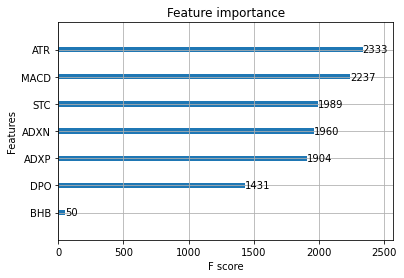

In [42]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [43]:
model.save_model("model.json")

In [44]:
#xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [45]:
#x =xgb_model_loaded.predict(X_test)
#x

In [46]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [47]:
file_name = "xgb_reg.pkl"
pickle.dump(clf, open(file_name, "wb"))